## Array Analysis

In [1]:
# Parameters
experiment_config_path = None
experiment_output_dir = None
force_view_calculation = False
na_growth_rate_fill_value = None

In [2]:
# # Debugging
# experiment_config_path = '/lab/repos/celldom/config/experiment/exp-20180614-G3-K562-imatinib-poc-01.yaml'
# # experiment_output_dir = '/lab/data/celldom/output/20180923-G3-full'
# #experiment_output_dir = '/lab/data/celldom/output/20181115-G3-sample-array-tzero'
# experiment_output_dir = '/lab/data/celldom/output/20181005-G3-full'
# force_view_calculation = False
# na_growth_rate_fill_value = 0

In [3]:
assert experiment_config_path, 'Must provide value for parameter `experiment_config_path`'
assert experiment_output_dir, 'Must provide value for parameter `experiment_output_dir`'

if na_growth_rate_fill_value is not None:
    na_growth_rate_fill_value = float(na_growth_rate_fill_value)

In [4]:
%run -m celldom.nb.logging
%matplotlib inline
import celldom
import os
import os.path as osp
import numpy as np
import pandas as pd
import plotnine as pn
import matplotlib.pyplot as plt
from skimage import io
from celldom.core.experiment import Experiment
from celldom.config import experiment_config
from celldom.execute import view
from celldom import ops

In [5]:
config = experiment_config.ExperimentConfig(experiment_config_path)
experiment = Experiment(config, data_dir=experiment_output_dir)
view.build_all(experiment, force=force_view_calculation)

In [6]:
def get_apartment_summary_data():
    df = experiment.get_view_store().get('apartment_summary')
    df = view.remove_oob_apartments(experiment, df)
    df['array'] = df[config.experimental_condition_fields].apply(':'.join, axis=1)
    return df

df = get_apartment_summary_data()

2018-11-28 17:06:59,626:INFO:celldom.execute.view: Removing 43 rows of 15637 from data frame with apartment/street numbers outside of expected range (apartment range = [0, 57], street range = [0, 15])


In [7]:
df.groupby('array')['growth_rate'].describe().sort_values('mean')\
    .style.set_caption('Growth rate distribution statistics by array')

,count,mean,std,min,25%,50%,75%,max
array,,,,,,,,
gravity:Red:3:0.5uM,578,-0.230263,0.149171,-0.485585,-0.345216,-0.279912,-0.129832,0.260298
gravity:Green:3:0.3uM,613,-0.215482,0.105089,-0.474636,-0.290136,-0.231648,-0.186222,0.185985
gravity:Green:1:0.3uM,599,-0.212982,0.108712,-0.450276,-0.289859,-0.23152,-0.179603,0.143637
gravity:Red:1:0.5uM,565,-0.145101,0.155687,-0.42435,-0.289893,-0.134006,-0.0183215,0.334252
gravity:White:1:Control,665,-0.119948,0.24218,-0.455774,-0.300046,-0.149573,-0.00788507,1.20354
gravity:Yellow:1:0.3uM,569,-0.0708416,0.204067,-0.464679,-0.249025,-0.0737188,0.0850903,0.472138
gravity:Yellow:3:0.3uM,558,-0.0682353,0.202283,-0.473885,-0.235376,-0.0659319,0.0757395,0.509973
gravity:Pink:1:0.5uM,452,-0.0500713,0.158377,-0.446986,-0.164762,-0.0237984,0.0635571,0.325471
gravity:Pink:3:0.5uM,407,-0.0112997,0.156503,-0.469684,-0.105106,0.00454105,0.0975097,0.305787


### Growth Rates

These heatmaps show growth rates for individual apartments where any individual growth rate may be missing due to:
- Apartment not ever identified in raw images
- Only a single cell count is present (growth rates for one time point not possible)
- Apartment does not meet the initial conditions criteria (single_cell, double_cell, etc.)

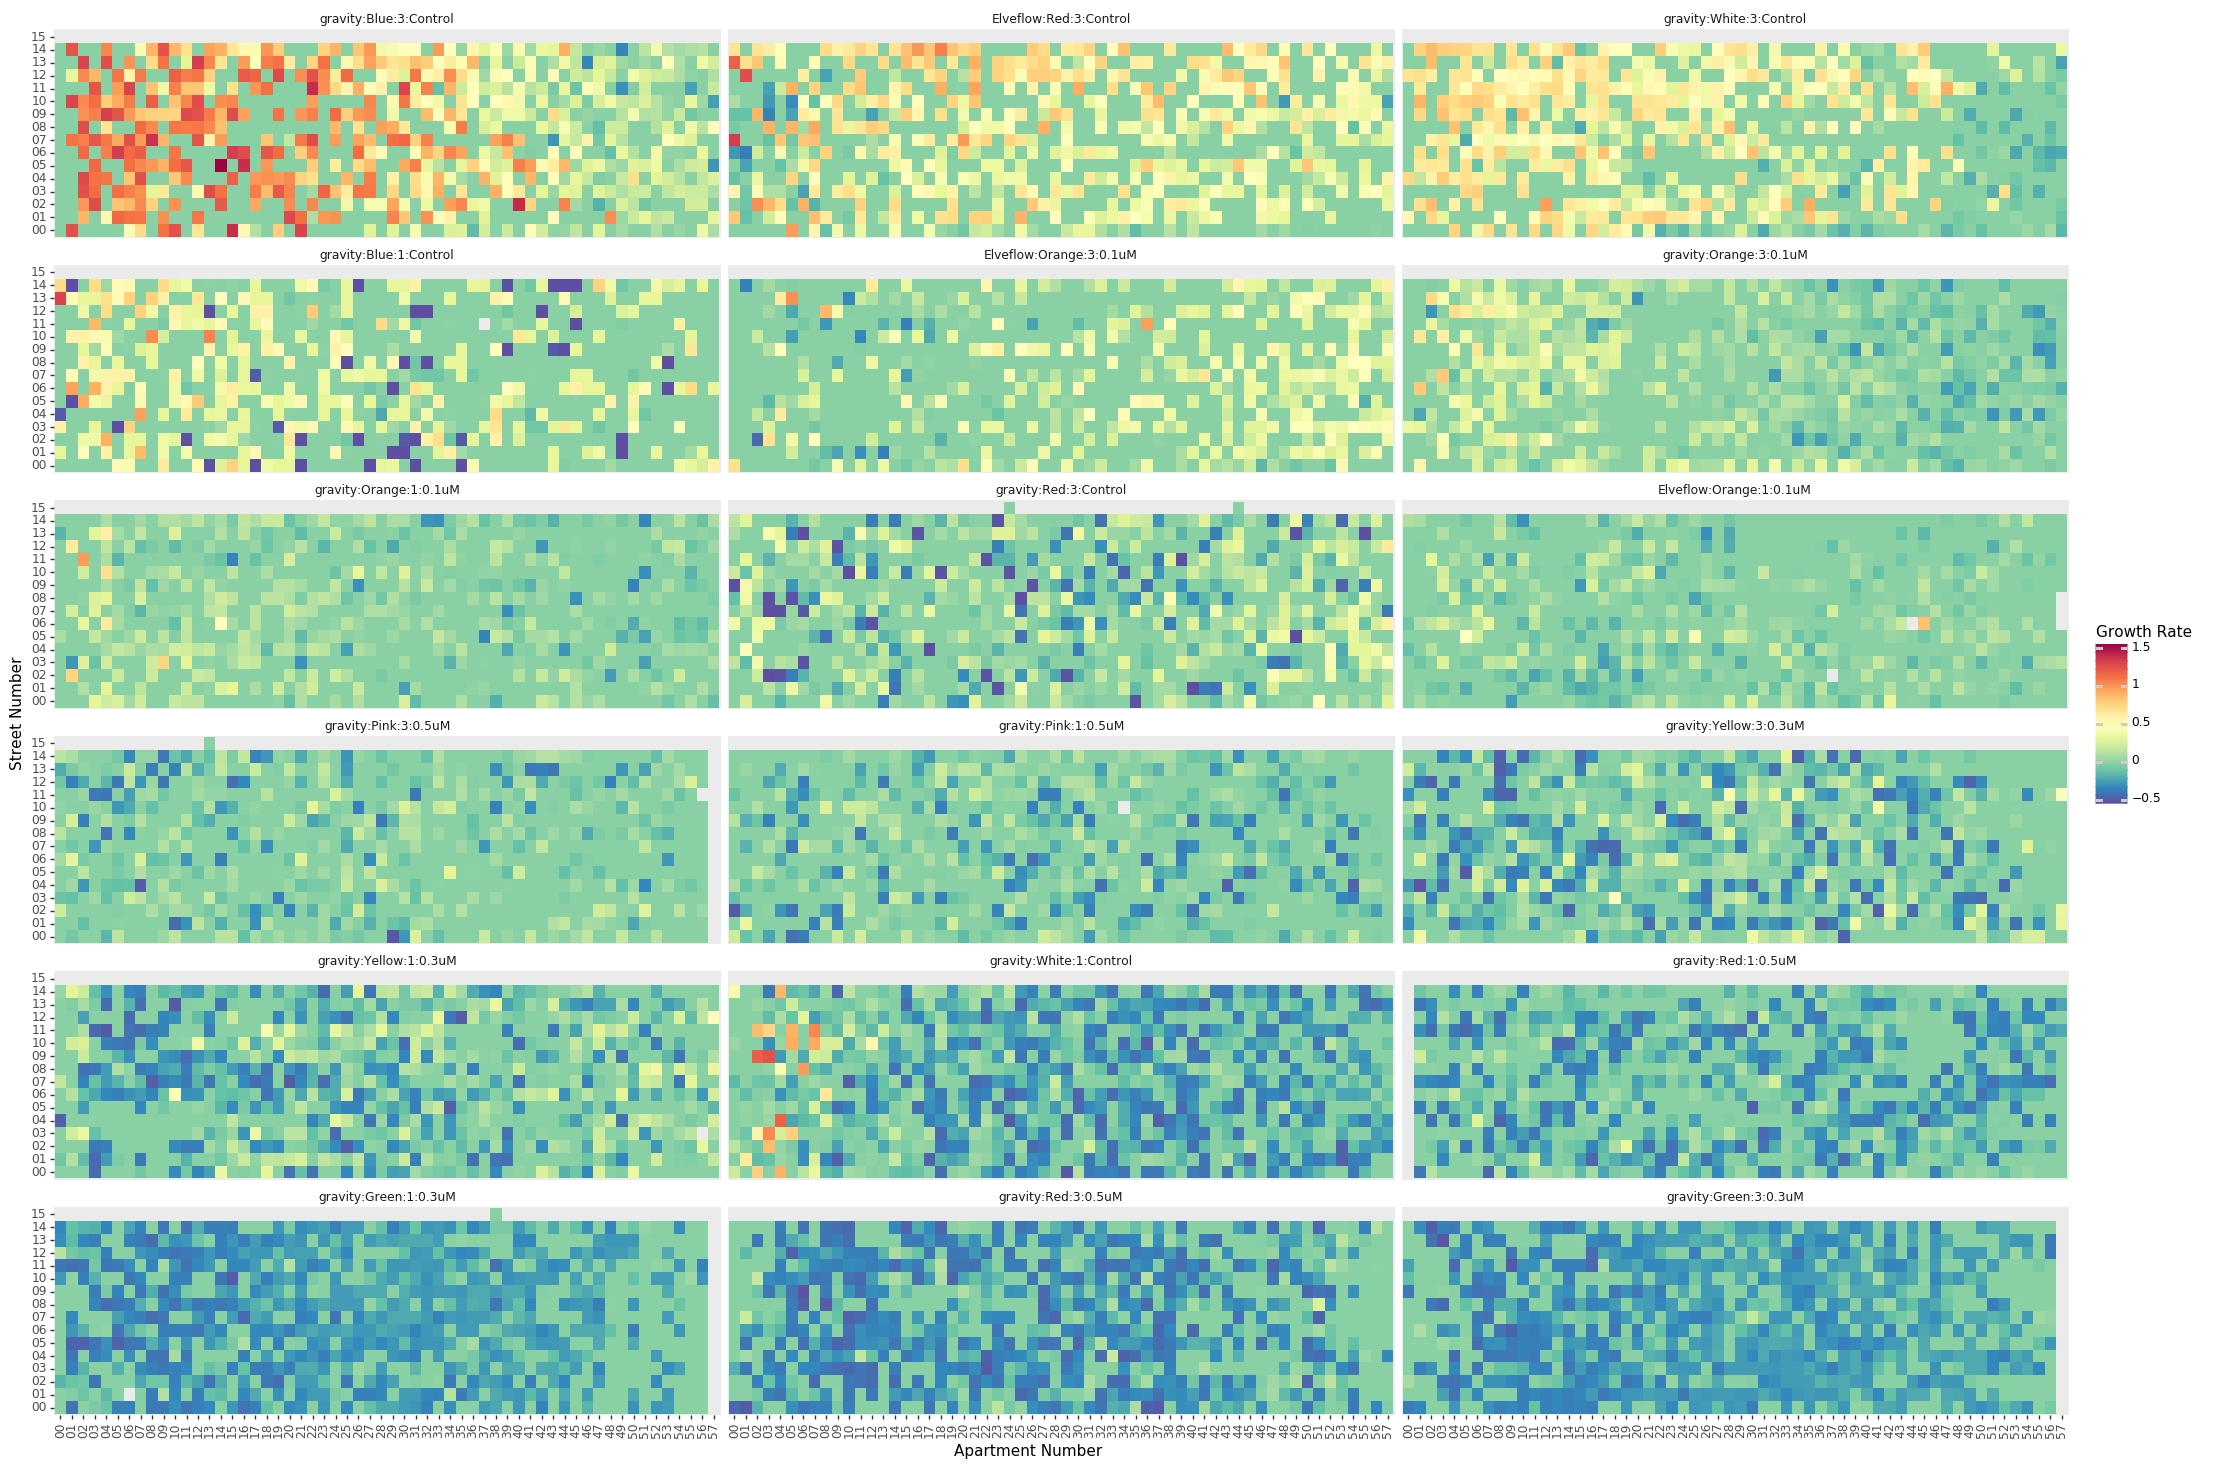

<ggplot: (8739185923627)>

In [8]:
n_array = df['array'].nunique()
(
    pn.ggplot(
        (
            (
                df[df['growth_rate'].notnull()] if na_growth_rate_fill_value is None 
                else df.assign(growth_rate=df['growth_rate'].fillna(na_growth_rate_fill_value))
            )
            .assign(array=lambda d: pd.Categorical(
                d['array'], ordered=True,
                categories=d.groupby('array')['growth_rate'].mean().sort_values(ascending=False).index
            ))
            .rename(columns={'growth_rate': 'Growth Rate'})
        ), 
        pn.aes(x='apt_num', y='st_num', fill='Growth Rate')
    ) +
    pn.geom_tile() +
    pn.scale_fill_cmap(name='Spectral_r', limits=(-.5, 1.5)) +
    pn.facet_wrap('~array', ncol=3) +
    pn.xlab('Apartment Number') +
    pn.ylab('Street Number') +
    pn.theme(
        figure_size=(26, 3 * int(np.ceil(n_array / 3))),
        axis_text_x=pn.element_text(rotation=90, hjust=.5),
        panel_grid_major=pn.element_blank(),
        panel_grid_minor=pn.element_blank(),
        strip_background=pn.element_rect(fill="white")
    )
)

### Confluence

This heatmap indicates apartments that ever reached a state of "confluence":

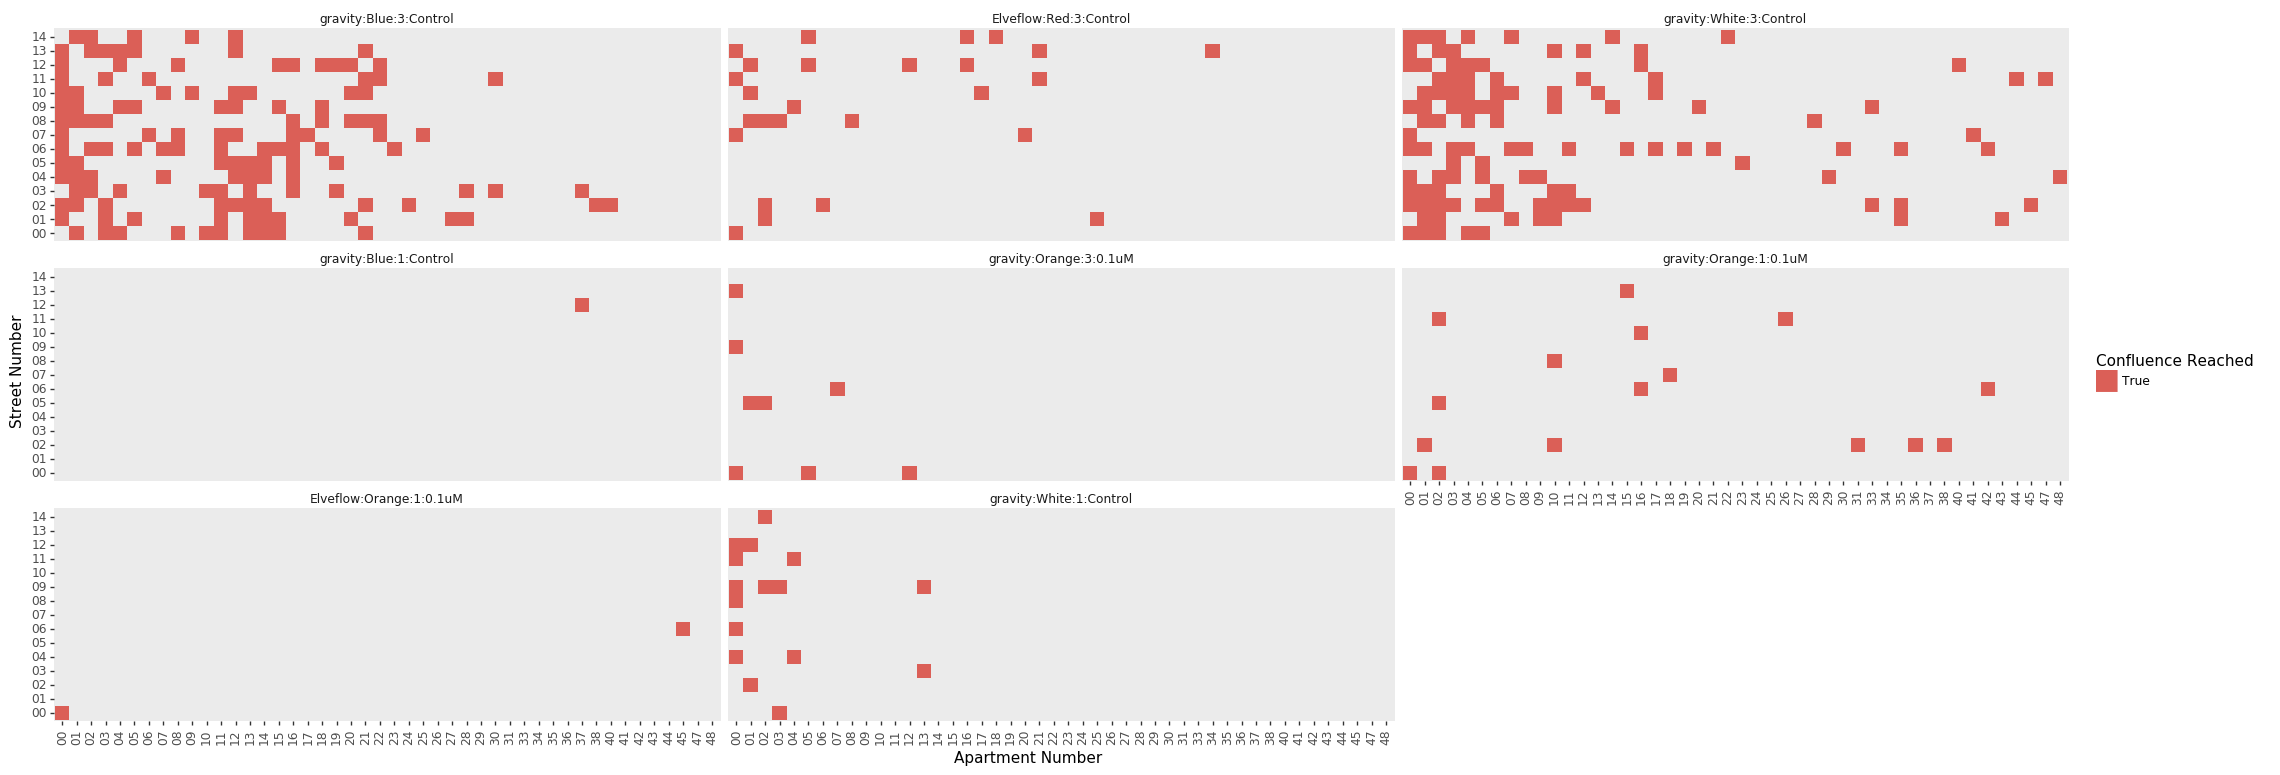

<ggplot: (8739184532428)>

In [9]:
import json
df_conf = (
    df
    .assign(confluence=df['confluence'].apply(lambda v: np.max(list(json.loads(v).values()))))
    .assign(array=pd.Categorical(
        df['array'], ordered=True,
        categories=df.groupby('array')['growth_rate'].mean().sort_values(ascending=False).index
    ))
    .loc[lambda d: d['confluence'] == True]
    .rename(columns={'confluence': 'Confluence Reached'})
)
n_array = df_conf['array'].nunique()
def disp():
    if len(df_conf) > 0:
        return (
            pn.ggplot(
                df_conf, 
                pn.aes(x='apt_num', y='st_num', fill='Confluence Reached')
            ) +
            pn.geom_tile() +
            pn.facet_wrap('~array', ncol=3) +
            pn.xlab('Apartment Number') +
            pn.ylab('Street Number') +
            pn.theme(
                figure_size=(26, 3 * int(np.ceil(n_array / 3))),
                axis_text_x=pn.element_text(rotation=90, hjust=.5),
                panel_grid_major=pn.element_blank(),
                panel_grid_minor=pn.element_blank(),
                strip_background=pn.element_rect(fill="white")
            )
        )
disp()

### Trapping Efficiency

This table shows what percentage of apartments in each array began with a single cell (as well as other cell counts):

In [10]:
def get_pivot_data(df, count_field):
    if count_field not in df:
        return None
    def classify(ct):
        if pd.isnull(ct):
            return 'No t0'
        ct = int(round(ct))
        return str(ct) if ct < 5 else '5+'
    dfc = (
        df
        .assign(initial_cell_count=df[count_field].apply(classify))
        .groupby(config.experimental_condition_fields + ['initial_cell_count']).size().rename('count')
        .unstack()
    )
    dfn = dfc.sum(axis=1)
    dfp = dfc.divide(dfn, axis=0)
    dfo = pd.concat([dfp, dfn.rename('n_apartments')], axis=1)
    dfo.columns.name = 'initial_cell_count'
    return dfo

def disp(df):
    if df is None:
        return 'No data for component available'
    if '1' in df:
        return (
            df.sort_values('1', ascending=False)
            .style.background_gradient(subset='1', cmap='RdYlGn')
            .format('{:.1%}', subset=[c for c in df.columns if c != 'n_apartments'])
        )
    else:
        return dfo

*Chamber Percentages:*

In [11]:
count_field = 'tz_count_any_chamber'
disp(get_pivot_data(df, count_field))

*Trap Percentages:*

In [12]:
count_field = 'tz_count_any_trap'
disp(get_pivot_data(df, count_field))

'No data for component available'

### Average Cell Counts

These figures show the average number of cells across the arrays for each time point as well as predicted averages based on individual apartment growth rates.  This is limited to only counting cells in apartments that had a valid growth rate which also means that apartments not meeting the original initial conditions criteria (which is usually ```'single_cell'```) are excluded.

Also, regardless of the apartment filtering criteria, the number of apartments detected and quantified for each array and time point is rarely uniform.  This means that because the number of apartments differ slightly, average cell counts are used instead of total cell counts:

In [13]:
# Compute estimate average cell counts across whole arrays (based on apartment growth rate)

hours = np.arange(0, df['last_hour'].max() + 24, 24)

def get_pop_pred(g):
    g = g[['growth_rate_intercept', 'growth_rate']].dropna()
    b0, b1 = g['growth_rate_intercept'], g['growth_rate']
    n, m = len(g), len(hours)
    
    # Reshape to (n, 1)
    b0, b1 = np.expand_dims(b0.values, -1), np.expand_dims(b1.values, -1)
    
    # Repeat hours array n times (e.g. 0, 1, 2, 0, 1, 2) and reshape to (n, m)
    # where m is number of horus
    t = np.tile(hours/24, n).reshape((-1, m))
    assert t.shape == (n, m)
    
    # Multiply growth rates (n, 1) by hours/24 (n, m), add intercept, and exponentiate 
    # (i.e. invert original growth rate model)
    s = (2 ** (b0 + b1 * t)) - 1
    
    # Predicted cell counts should not be negative
    s = np.clip(s, 0, np.inf)
    
    # Sum estimate counts across n apartments to give resulting mean vector of length m
    return pd.Series(s.mean(axis=0), index=hours)
    

df_est = df.groupby('array').apply(get_pop_pred)
df_est.columns.name = 'hour'
df_est = df_est.stack().rename('mean_cell_count').reset_index()
df_est.head()

,array,hour,mean_cell_count
0,Elveflow:Orange:1:0.1uM,0,2.193448
1,Elveflow:Orange:1:0.1uM,24,2.234317
2,Elveflow:Orange:1:0.1uM,48,2.300096
3,Elveflow:Orange:1:0.1uM,72,2.394115
4,Elveflow:Orange:1:0.1uM,96,2.521552


In [14]:
count_field = 'cell_count_any_chamber'

# Create a set of apartment addresses with valid growth rates to restrict counting to
apt_addresses = df[df['growth_rate'].notnull()][config.apartment_address_fields].apply(':'.join, axis=1).unique()

# Load apartment data (with time) instead of apartment summaries across time
def get_apartment_data():
    df = experiment.get_view_store().get('apartment')
    df = view.remove_oob_apartments(experiment, df)
    df['array'] = df[config.experimental_condition_fields].apply(':'.join, axis=1)
    df['address'] = df[config.apartment_address_fields].apply(':'.join, axis=1)
    df = ops.filter(df, df['address'].isin(apt_addresses), 'Apts w/ valid growth rate')
    return df
df_ct = get_apartment_data()



df_ct = (
    df_ct
    .groupby(['array', 'elapsed_hours_group'])[count_field]
    .agg(['mean', 'count'])
    .reset_index()
    .rename(columns={'mean': 'mean_cell_count', 'count': 'n_apt', 'elapsed_hours_group': 'hour'})
)
df_ct['mean_cell_count'] = df_ct['mean_cell_count'].round(2)
df_ct['n_apt'] = pd.cut(df_ct['n_apt'].astype(int), 5, precision=0)
assert df_ct['n_apt'].notnull().all()
n_array = df_ct['array'].nunique()

df_ct.head()

2018-11-28 17:07:11,681:INFO:celldom.execute.view: Removing 64 rows of 136460 from data frame with apartment/street numbers outside of expected range (apartment range = [0, 57], street range = [0, 15])
2018-11-28 17:07:17,358:INFO:celldom.ops: [Filter = Apts w/ valid growth rate] Removing 54762 records of 136396 (40.15%)


,array,hour,mean_cell_count,n_apt
0,Elveflow:Orange:1:0.1uM,0,1.00,"(342.0, 407.0]"
1,Elveflow:Orange:1:0.1uM,21,2.51,"(342.0, 407.0]"
2,Elveflow:Orange:1:0.1uM,45,2.53,"(342.0, 407.0]"
3,Elveflow:Orange:1:0.1uM,74,3.67,"(342.0, 407.0]"
4,Elveflow:Orange:1:0.1uM,100,4.42,"(342.0, 407.0]"


In [23]:
def disp(scales):
    array_order = df_ct.groupby('array')['mean_cell_count'].mean().sort_values(ascending=False).index
    array_max = df_ct.groupby('array')['mean_cell_count'].max()
    
    df1 = df_ct.assign(array=pd.Categorical(df_ct['array'], ordered=True, categories=array_order))
    df2 = (
        df_est
        .assign(count_max=df_est['array'].map(array_max))
        .assign(array=pd.Categorical(df_est['array'], ordered=True, categories=array_order))
        .assign(mean_cell_count=lambda d: np.minimum(d['mean_cell_count'], d['count_max']))
    )
    
    return (
        pn.ggplot(pn.aes(x='hour', y='mean_cell_count', label='mean_cell_count')) + 
        pn.geom_line(data=df1, alpha=.5, linetype='solid') +  
        pn.geom_point(data=df1, mapping=pn.aes(color='n_apt'), alpha=.3, size=4) + 
        pn.geom_text(data=df1, size=8, va='bottom') + 
        pn.geom_line(data=df2, alpha=.5, linetype='dashed') +
        pn.facet_wrap('~array', ncol=2, scales=scales) + 
        pn.labs(x='Acquisition Hour', y='Average Cell Counts', color='Num Apartments') +
        pn.ggtitle('Predicted (dashed) and Actual (solid) Average Cell Counts') +
        pn.theme_bw() +
        pn.theme(
            figure_size=(16, 3 * int(np.ceil(n_array / 2))),
            panel_grid_minor=pn.element_blank()
        )
    )

*Average cell counts with fixed y axis (for inter-array comparison)*:

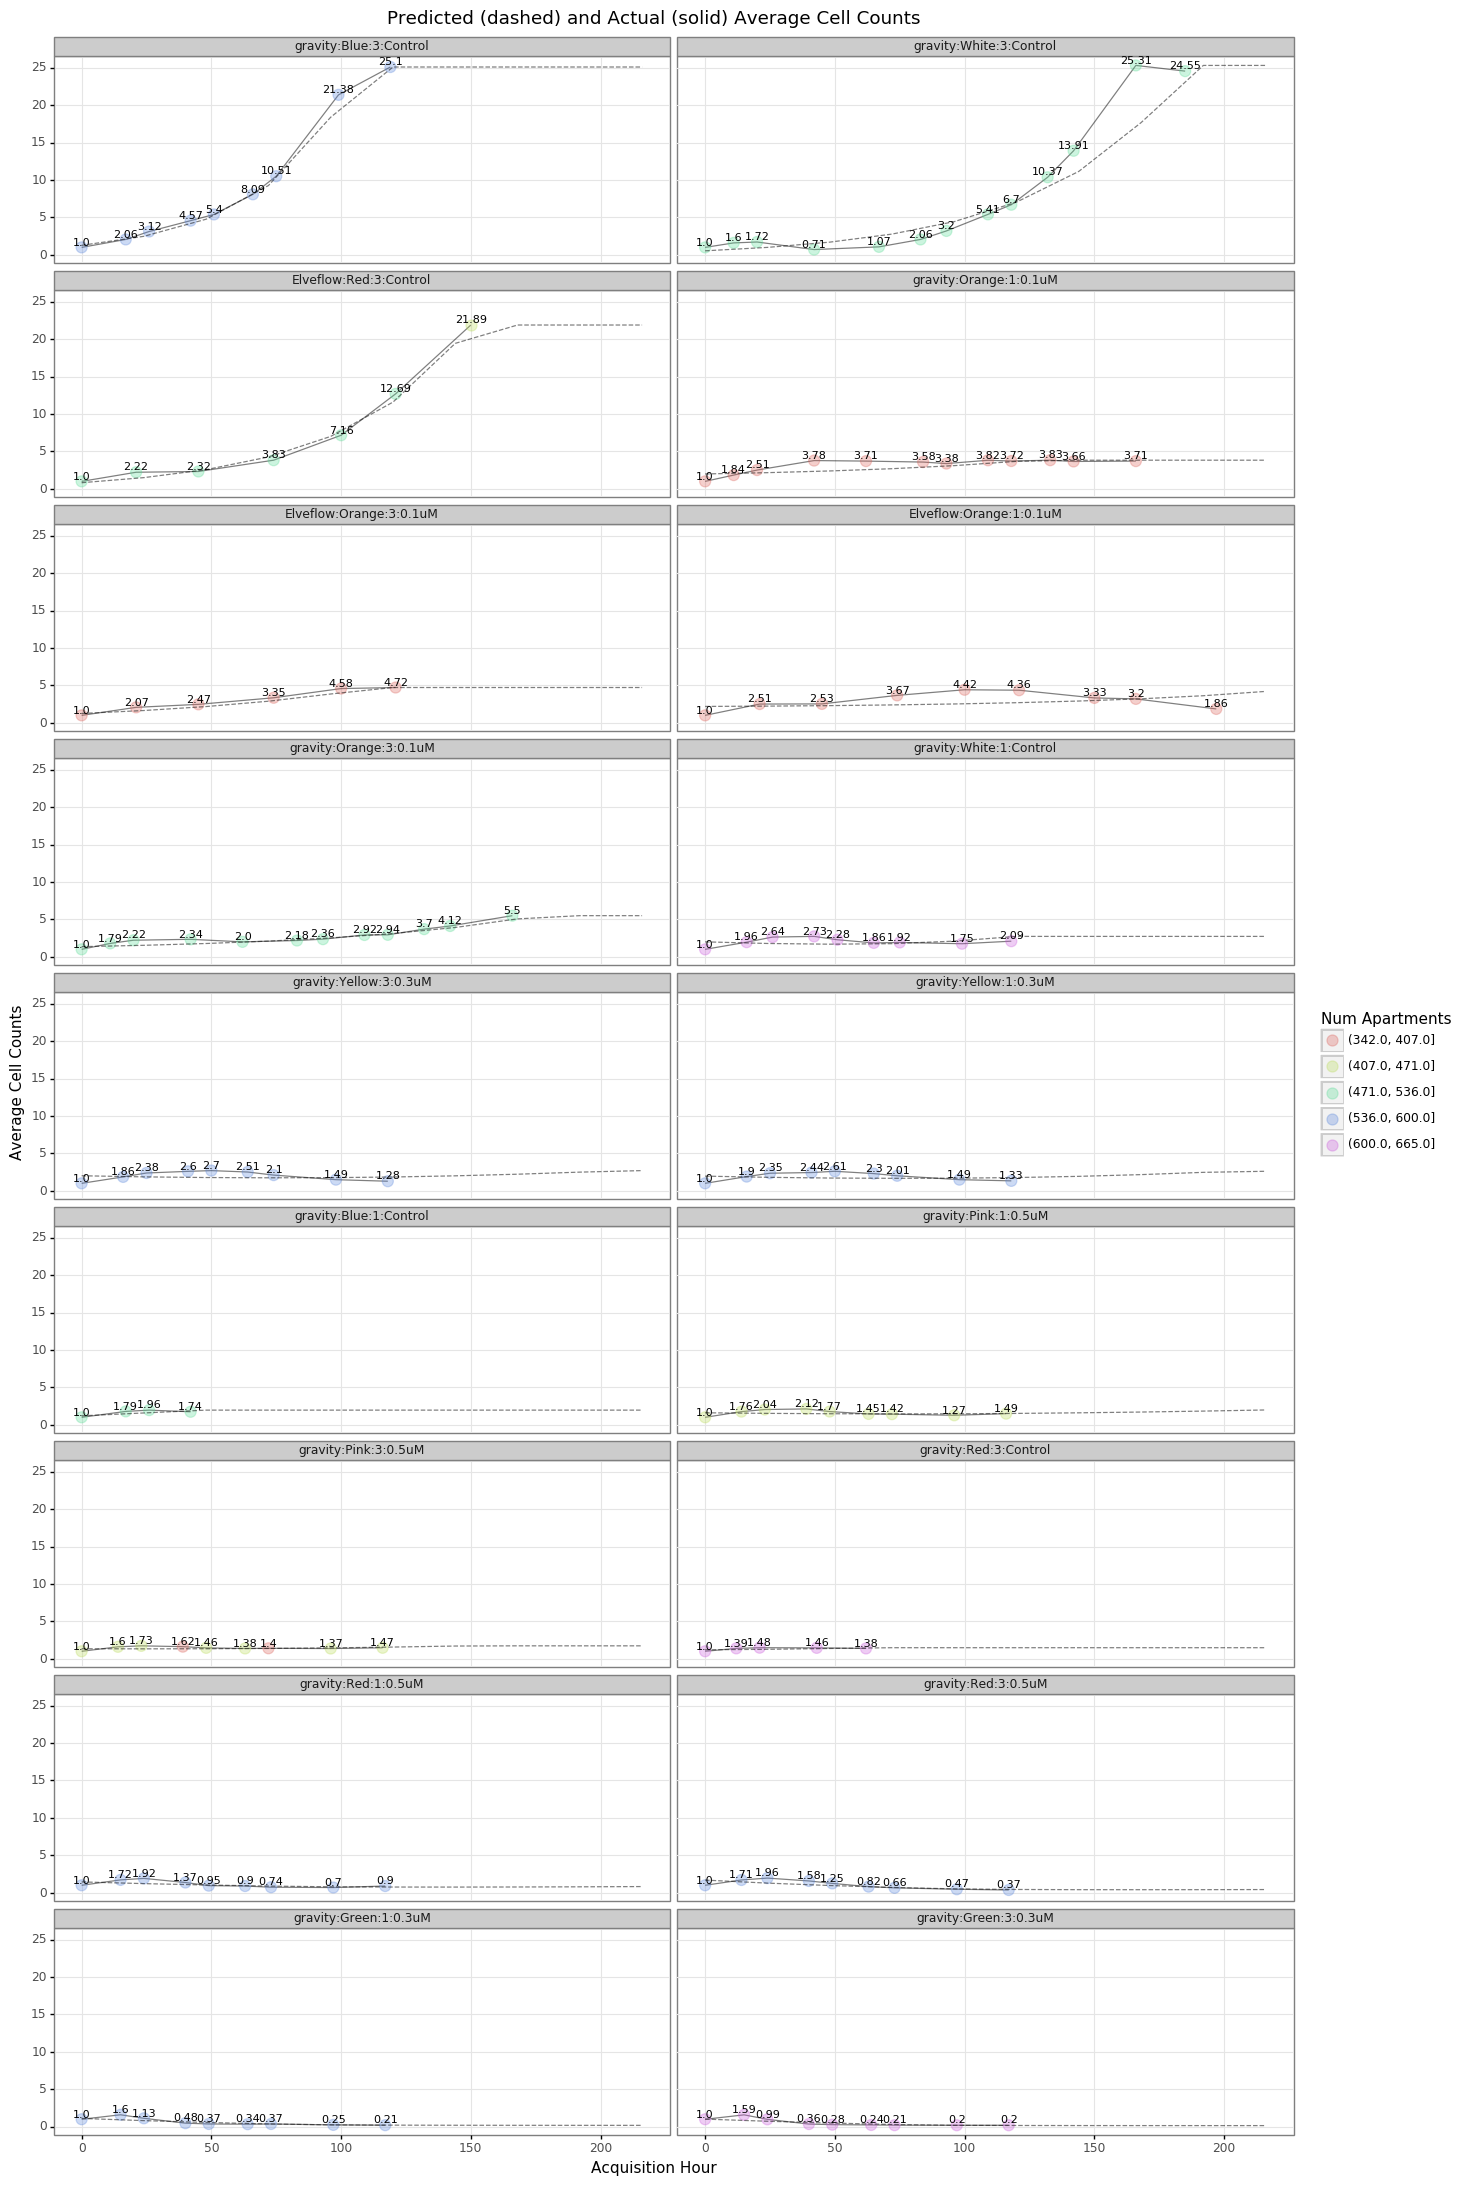

<ggplot: (-9223363297669843326)>

In [24]:
disp('fixed')

*Average cell counts with variable y axis (for intra-array comparison)*:

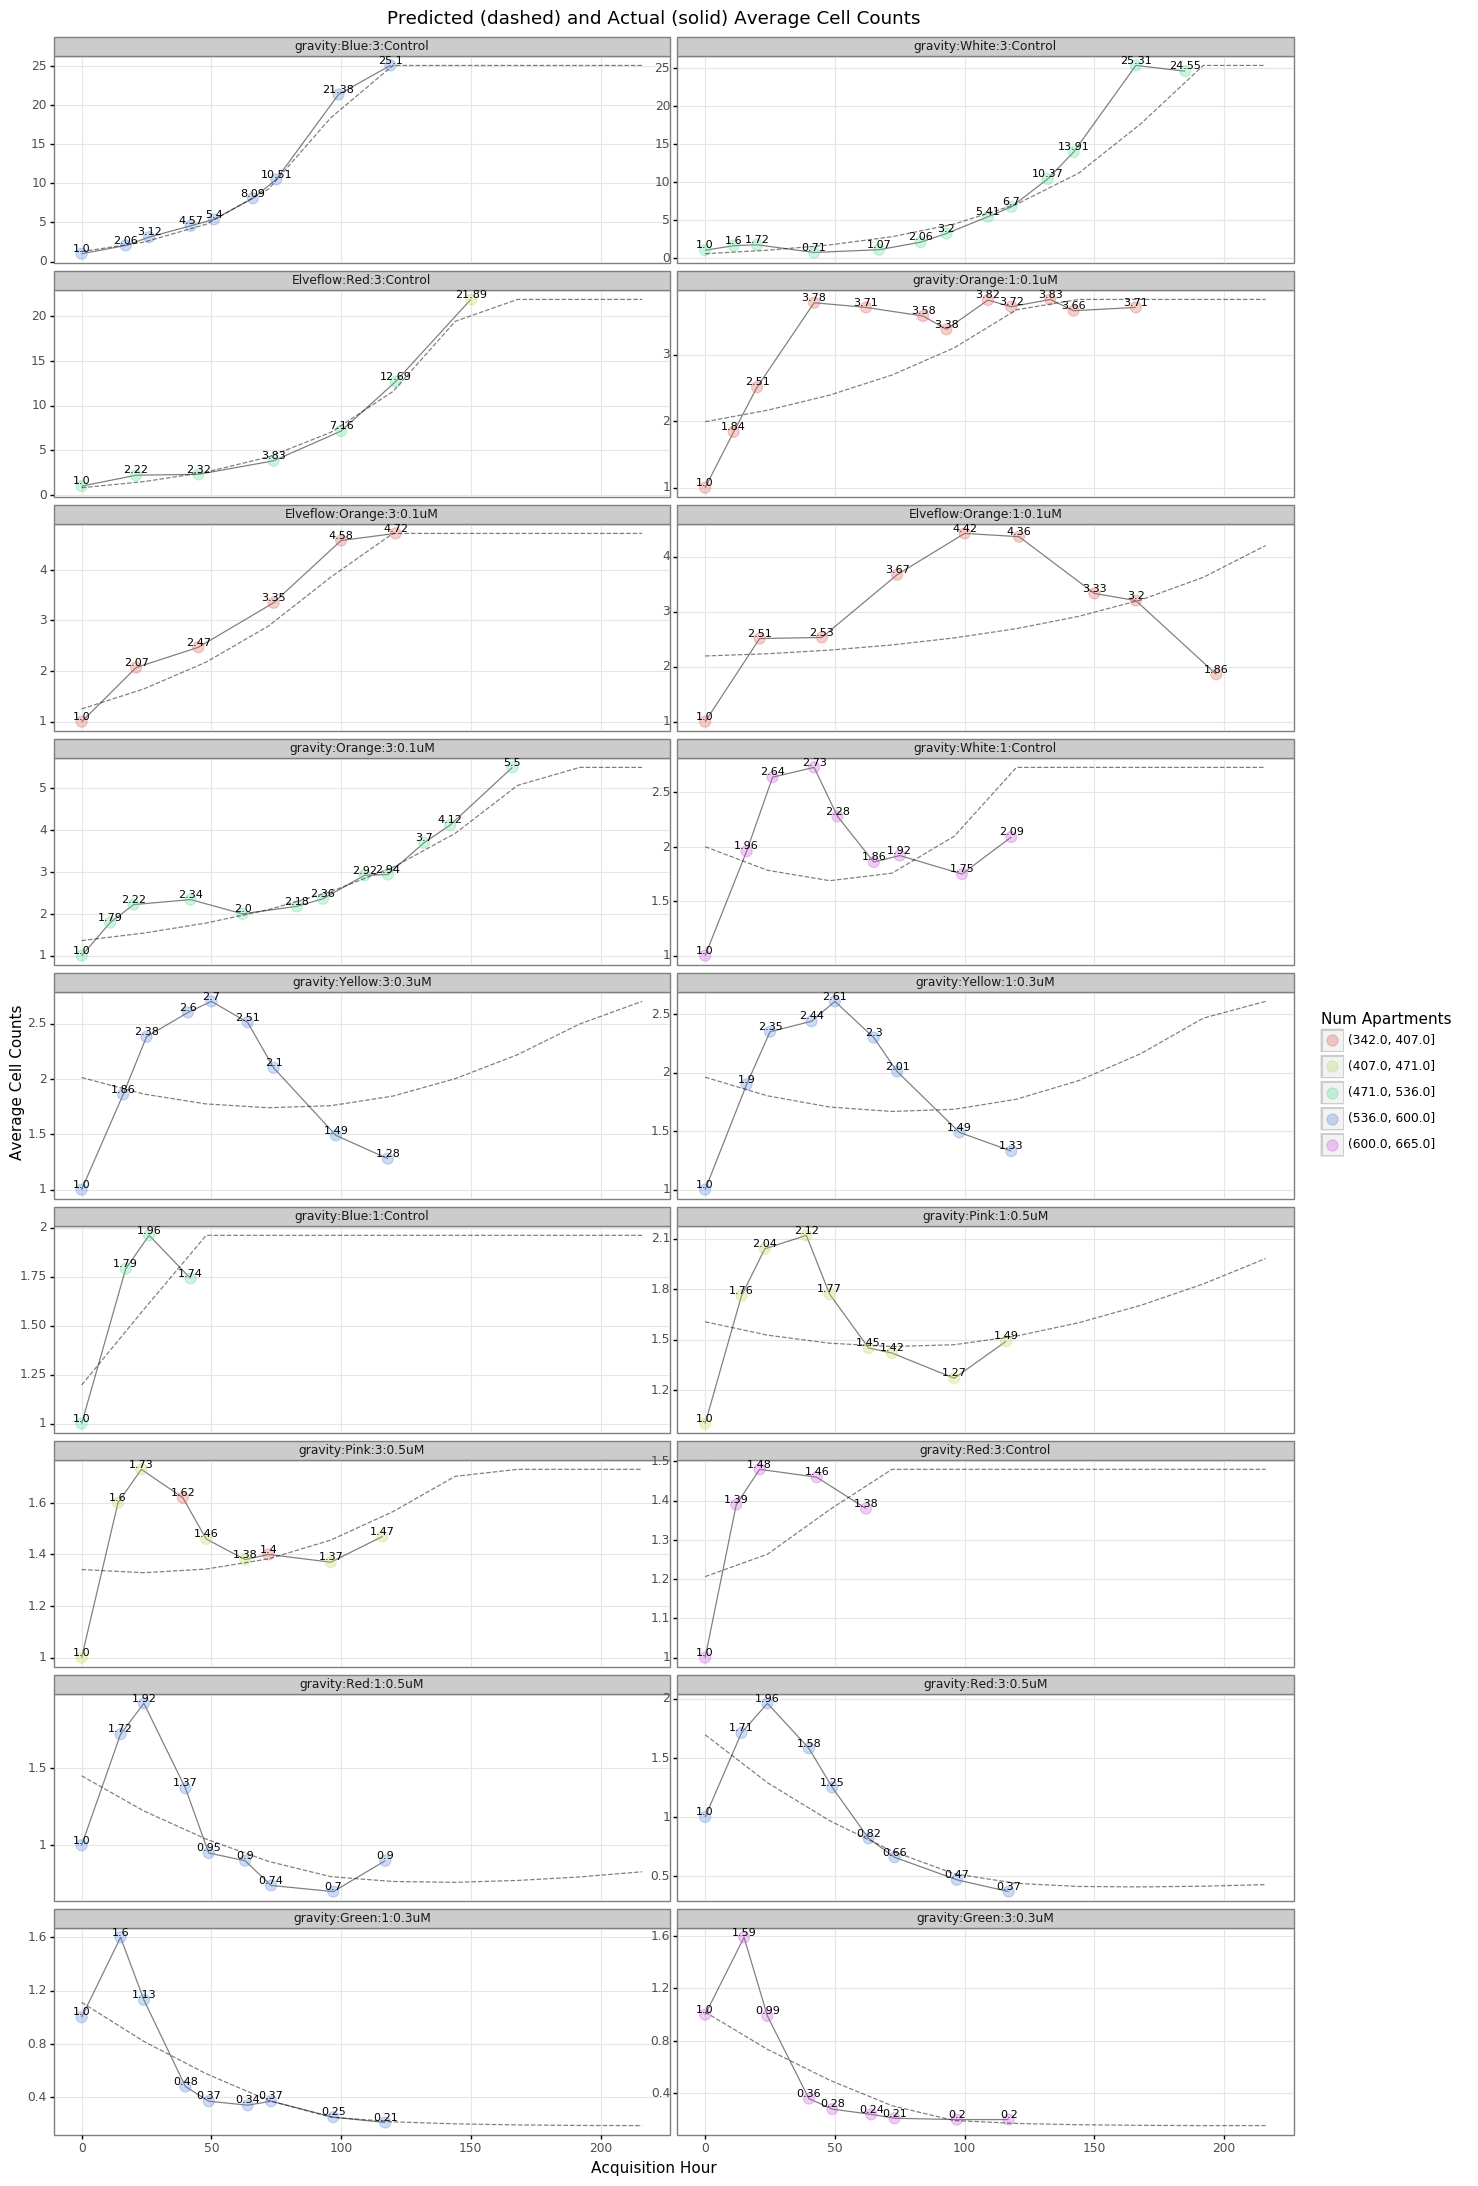

<ggplot: (-9223363297669715105)>

In [25]:
disp('free_y')